In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip3 install python-mnist
# !wget https://github.com/sorki/python-mnist/blob/master/bin/mnist_get_data.sh
# !mnist_get_data.sh

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import time

import torch
import matplotlib.pylab as plt
from tqdm.notebook import tqdm, trange
import numpy as np
from scipy.spatial.distance import cdist
from mnist import MNIST
from IPython.display import clear_output

# sys.path.append('/content/drive/MyDrive/Documents/OPTAMI/OPTAMI')
# sys.path.append('/content/drive/MyDrive/Documents/OPTAMI')
from OPTAMI import PrimalDualAccelerated, BDGM
from run_pd_experiment import *

In [3]:
n = 784
m = int(np.sqrt(n))

In [4]:
device = 'cuda:1'
# device = 'cpu'

In [5]:
# A_A_T_path = 'A_A_T.pkl'
# if not os.path.exists(A_A_T_path):
#     A_matrix = calculate_A_matrix(n)
#     A_A_T = A_matrix @ A_matrix.T
#     torch.save(A_A_T, A_A_T_path)
# else:
#     A_A_T = torch.load(A_A_T_path)

# Fast gradient method for dual function

In [113]:
def fast_gradient_method(
    L, 
    M_matrix,
    primal_function, 
    dual_function, 
    primal_var_function,
    round_function,
    b,
    eps,
    eps_tilde,
    max_steps=None,
    device='cpu'
):
    
    dual_var_next = torch.zeros(2 * n, requires_grad=True, dtype=torch.double, device=device)
    y_next = torch.zeros(2 * n, dtype=torch.double, device=device)
    z_next = torch.zeros(2 * n, dtype=torch.double, device=device)
    k = 0
    one_over_L = 1 / L
    alpha_next = one_over_L
    sum_of_y = y_next
    cr_1_list = []
    cr_2_list = []
    while True:
        y = y_next.detach().clone()
        z = z_next.detach().clone()
        tau = 2 / (k + 2)
        
        with torch.no_grad():
            dual_var_next = tau * z + (1 - tau ) * y
            dual_var_next.requires_grad_(True)
            # dual_var_next.add_(z, alpha=tau).add_(y, alpha=1 - tau)
        
        phi_next = dual_function(dual_var_next)
        grad_phi_next = torch.autograd.grad(phi_next, dual_var_next)
        y_next = dual_var_next.detach().clone() - one_over_L * grad_phi_next[0]
        
        z_next = z - alpha_next * grad_phi_next[0]
        
        N = k + 1
        
        y_tilde = 1 / (N * (N + 3)) * (sum_of_y + (N + 1) ** 2 * y_next)
        sum_of_y += y_next
        
        primal_var, _, _ = primal_var_function(dual_var_next)
        
        
        F_value = dual_function(y_tilde)
        g_value = primal_function(primal_var)
        cr_1 = torch.abs(F_value + g_value)
        cr_2 = (M_matrix * (round_function(primal_var) - primal_var)).sum()
        cr_1_list.append(cr_1.detach().clone().item())
        cr_2_list.append(cr_2.detach().clone().item())
#         cr_2 = torch.norm(A_matrix @ primal_var - b)
        if k == 0:
            init_cr_1 = cr_1
            init_cr_2 = cr_2
            init_phi = F_value.item()
            init_f = g_value.item()
        clear_output(wait=True)
        print('\n'.join([
            f'Step #{k}', 
            f'cr_1: {init_cr_1} -> {cr_1}',
            f'cr_2: {init_cr_2} -> {cr_2}',
            f'phi: {init_phi} -> {F_value.item()}',
            f'f: {init_f} -> {g_value.item()}',            
        ]))
        
        if cr_1 <= eps and cr_2 <= eps_tilde:
            break
        
        
        alpha_next = (k + 2) * one_over_L / 2
        k += 1
        
        if max_steps is not None:
            if k == max_steps:
                break
        
    return F_value, g_value, primal_var, dual_var_next, cr_1_list, cr_2_list

In [114]:
gamma = 1
eps = 0.0001
image_index = 0

In [115]:
eps, gamma

(0.0001, 1)

In [116]:
images, labels = load_data()

p_list = [34860, 31226, 239, 37372, 17390]
q_list = [45815, 35817, 43981, 54698, 49947]

# x_array = np.linspace(1 / 2e-2, 1 / 4e-4, 6)
# epslist = 1 / x_array
epsp = eps / 8
p, q = mnist(epsp, p_list[image_index], q_list[image_index], images, n)
p_ref, q_ref = mnist(0, p_list[image_index], q_list[image_index], images, n)
p = torch.tensor(p, device=device).double()
q = torch.tensor(q, device=device).double()
p_ref = torch.tensor(p_ref, device=device).double()
q_ref = torch.tensor(q_ref, device=device).double()
b = torch.cat((p, q))

In [117]:
M_matrix = calculate_M_matrix(m).to(device)

In [118]:
M_1 = calculate_lipschitz_constant(n, gamma, p_order=1, A_A_T=None, device=device)
M_1

2.0000000000000004

In [119]:
ones = torch.ones(n, device=device, dtype=torch.double)
primal_func = lambda x: f(x, M_matrix, gamma, device)
dual_func = lambda lamb: phi(lamb, n, gamma, M_matrix / gamma, ones, p, q)
primal_var_func = lambda lamb: calculate_x(lamb, n, gamma, M_matrix / gamma, ones)
round_func = lambda primal_var: B_round(primal_var, p_ref, q_ref, ones)

In [121]:
%%time
F_value, g_value, primal_var, dual_var, fgm_cr_1_list, fgm_cr_2_list = fast_gradient_method(
    M_1, 
    M_matrix,
    primal_func, 
    dual_func, 
    primal_var_func, 
    round_func,
    b, 
    eps, 
    eps, 
    device=device
)

Step #14609
cr_1: 0.006441196313026865 -> 9.99798763228199e-05
cr_2: -0.2552057551581488 -> -2.713995118596915e-06
phi: 12.41590585911262 -> 9.266104957556557
f: -12.422347055425647 -> -9.26620493743288
CPU times: user 1min 2s, sys: 6.07 s, total: 1min 8s
Wall time: 1min 3s


In [124]:
dual_var.shape

torch.Size([1568])

In [95]:
u = primal_var.detach().clone().cpu() @ ones.cpu()

In [123]:
u.shape

torch.Size([784])

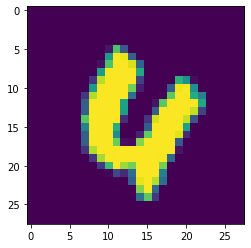

In [96]:
plt.imshow(u.reshape(28, 28))

# Primal-Dual Tensor Method

In [97]:
M_p = calculate_lipschitz_constant(n, gamma, p_order=3, A_A_T=None, device=device)

In [98]:
M_p

60.000000000000014

In [107]:
M_matrix = calculate_M_matrix(m)
M_matrix = M_matrix.to(device)
ones = torch.ones(n, device=device, dtype=torch.double)
lamb = torch.zeros(n * 2, dtype=torch.double, requires_grad=True, device=device)
optimizer = PrimalDualAccelerated(
    [lamb],
    M_p=M_p,
    p_order=torch.tensor(3, device=device),
    eps=0.01,
    calculate_primal_var=lambda lamb: calculate_x(lamb, n, gamma, M_matrix / gamma, ones)
)

Step #14999
cr_1: 0.01078735798353847 -> 0.029454315706413325
cr_2: -0.2550157741642701 -> -0.0008833065842026127
phi: 12.411553031126218 -> 9.267300505886645
f: -12.422340389109756 -> -9.296754821593058
time=13h, 26m, 48s


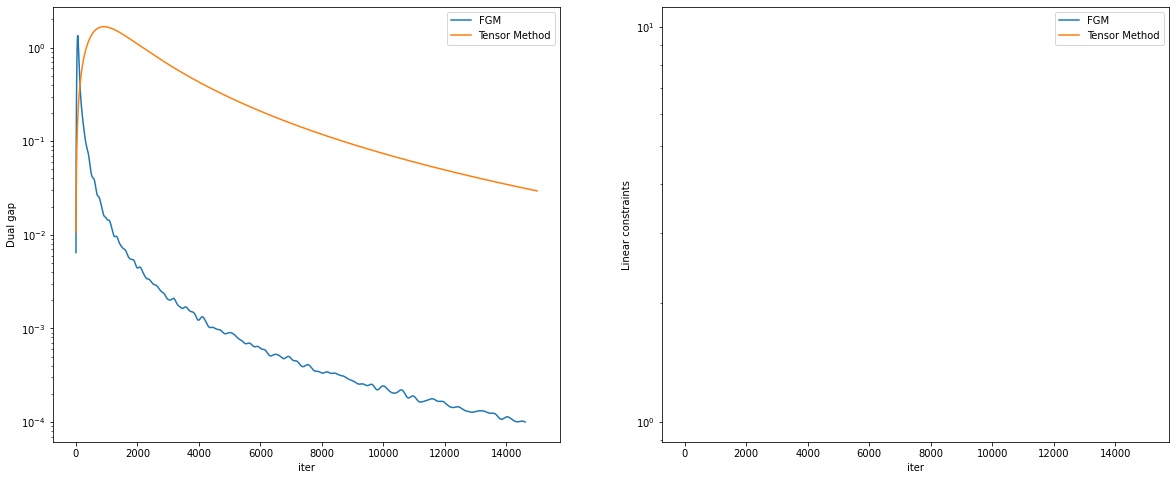

In [108]:
optimizer, i, cr_1, cr_2 = run_experiment(
    M_p,
    gamma, 
    eps, 
    image_index,
    optimizer=optimizer,
    max_steps=15000,
    fgm_cr_1_list=fgm_cr_1_list,
    fgm_cr_2_list=fgm_cr_2_list,
    device=device
)

In [112]:
optimizer.param_groups[0]['params'][0].norm().item()

130.61807993205085

## BDGM 

In [27]:
images, labels = load_data()
n = len(images[0])
m = int(np.sqrt(n))
gamma = torch.tensor(gamma, device=device)

M_matrix = calculate_M_matrix(m)
M_matrix = M_matrix.to(device)
M_matrix_over_gamma = M_matrix / gamma

# if A_matrix is None:
#     A_matrix = calculate_A_matrix(n).to(device)

# experiments were done for
p_list = [34860, 31226, 239, 37372, 17390]
q_list = [45815, 35817, 43981, 54698, 49947]

# x_array = np.linspace(1 / 2e-2, 1 / 4e-4, 6)
# epslist = 1 / x_array

epsp = eps / 8
p, q = mnist(epsp, p_list[image_index], q_list[image_index], images, n)
p = torch.tensor(p, device=device, dtype=torch.double)
q = torch.tensor(q, device=device, dtype=torch.double)
p_ref, q_ref = mnist(0, p_list[image_index], q_list[image_index], images, n)
p_ref = torch.tensor(p_ref, device=device, dtype=torch.double)
q_ref = torch.tensor(q_ref, device=device, dtype=torch.double)

ones = torch.ones(n, device=device, dtype=torch.double)

/tmp/ipykernel_1224861/3532352633.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gamma = torch.tensor(gamma, device=device)


In [31]:
lamb = torch.zeros(2 * n, requires_grad=True, device=device, dtype=torch.double)
optimizer = BDGM([lamb], L=M_p)
closure = lambda: phi(lamb, n, gamma, M_matrix_over_gamma, ones, p, q, optimizer=optimizer)
round_function = lambda X_matrix: B_round(X_matrix, p_ref, q_ref, ones)

M = M_p * 2
M_squared, M_p_squared = M ** 2, M_p ** 2
p_order = 3
A_factor = ((p_order - 1) * (M_squared - M_p_squared) /
                    (4 * (p_order + 1) * p_order ** 2 * M_squared)) ** (p_order / 2)

phi_values = [0.0] * 200
for i in range(200):
    optimizer.step(closure)
    with torch.no_grad():
        clear_output(wait=True)
        phi_value = closure().item()
        phi_values[i] = phi_value
        print(f'Step#{i}, phi={phi_value}')
#         A =  * (k / (p_order + 1)) ** (p_order + 1)
#         X_matrix, X_stable_sum, max_log_X = calculate_x(lamb, n, M_matrix_over_gamma, ones)
#         X_hat_matrix_next = 

Step#199, phi=558.2304380111552


# TEST (Code from Nazarii)

In [16]:
from mnist import MNIST
import numpy as np
from scipy.spatial.distance import cdist
import math
#https://pypi.org/project/python-mnist
mndata = MNIST('./data/')
images, labels = mndata.load_training()
%matplotlib inline
import matplotlib.pyplot as plt
import copy
from numpy import linalg
import time

l = len(images)
n = len(images[0])
m = int(np.sqrt(n))

# def mnist(eps, p, q):
#     p, q = np.float64(images[p]), np.float64(images[q])
#     p, q = p / sum(p), q / sum(q)
    
#     p = (1 - eps / 8) * p + eps / (8 * n)
#     q = (1 - eps / 8) * q + eps / (8 * n)
    
#     return p, q

def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

C = np.arange(m)
C = cartesian_product(C, C)
C = cdist(C, C)
C /= np.max(C)
C.max()

1.0

In [17]:
one = np.ones(n, np.float64)
I = np.ones([n,n], np.float64)
def f_true(x):
    return (C * x).sum()

def B_round(x):
    r = p_ref / x.dot(one)
    r[r>1] = 1.
    F = np.diag(r).dot(x)
    c = q_ref / (x.T).dot(one)
    c[c>1] = 1.
    F = F.dot(np.diag(c))
    err_r = p_ref - F.dot(one)
    err_c = q_ref - (F.T).dot(one)
    return F + np.outer(err_r, err_c) / abs(err_r).sum()

In [18]:
def phi_(gamma, lamu):
    A = (-C/gamma + np.outer(lamu[:n], one) + np.outer(one, lamu[n:]))
    a = A.max()
    A-=a
    s = a+np.log(np.exp(A).sum())
    return gamma*(-lamu[:n].dot(p) - lamu[n:].dot(q) + s)

def f_(gamma, x):
    y = (x.reshape(-1)).copy()
    y[x.reshape(-1) == 0.] = 1.
    
    y = y.reshape(n, -1)
    return (C * x).sum() + gamma * (x * np.log(y)).sum()

In [23]:
def apd(x0, L):
    betta = 0.
    alpha = 0.
    primal_var = 0.*np.ones([n, n], dtype=np.float64)
    z = np.zeros(2*n, dtype=np.float64)
    z_new = np.zeros(2*n, dtype=np.float64)
    eta = np.zeros(2*n, dtype=np.float64)
    eta_new  = np.zeros(2*n, dtype=np.float64)
    grad_phi_new = np.zeros(2*n, dtype=np.float64)
    
    f = lambda x: phi_(gamma, x)
    f_primal = lambda x: f_(gamma, x)
    
    k=0
    start_time = time.perf_counter()
    while True:
        # L = L / 2
        # while True:
        alpha_new = (1 + np.sqrt(4*L*betta + 1)) / 2 / L
        betta_new = betta + alpha_new
        tau = alpha_new / betta_new
        lamu_new = tau * z + (1 - tau) * eta

        logB = (K + np.outer(lamu_new[:n], one) + np.outer(one, lamu_new[n:]))
        max_logB =logB.max()
        logB_stable = logB - max_logB

        B_stable = np.exp(logB_stable)
        u_hat_stable, v_hat_stable = B_stable.dot(one), B_stable.T.dot(one)

        Bs_stable = u_hat_stable.sum()

        phi_new = gamma*(-lamu_new[:n].dot(p) - lamu_new[n:].dot(q) + np.log(Bs_stable) + max_logB)
        grad_phi_new = gamma*np.concatenate((-p + u_hat_stable/Bs_stable, -q + v_hat_stable/Bs_stable),0)

        z_new = z - alpha_new * grad_phi_new
        eta_new = tau * z_new + (1-tau) * eta

        phi_eta = f(eta_new)

            # if phi_eta <= phi_new + grad_phi_new.dot(eta_new - lamu_new) + L * ((eta_new - lamu_new)**2).sum() / 2:
        alpha, betta = alpha_new, betta_new
        z = z_new.copy()
        eta = eta_new.copy()
            #     break    
            # L = L * 2
        primal_var = tau * B_stable/Bs_stable + (1 - tau) * primal_var
        
        cr_1 = abs(f_primal(primal_var) + phi_eta)
        cr_2 = (C * (B_round(primal_var) - primal_var)).sum()
        if k == 0:
            init_cr_1 = cr_1
            init_cr_2 = cr_2

        clear_output(wait=True)
        print('\n'.join([
            f'Step #{k + 1}', 
            f'cr_1: {init_cr_1} -> {cr_1}',
            f'cr_2: {init_cr_2} -> {cr_2}'
        ]))
        if cr_2 <= eps/6 and cr_1 <= eps/6:
            return time.perf_counter() - start_time
        
        k=k+1

In [26]:
x_array = np.linspace(1 / 2e-2, 1 / 4e-4, 6)
epslist = 1 / x_array

In [27]:
epslist

array([0.02      , 0.00185185, 0.00097087, 0.00065789, 0.00049751,
       0.0004    ])

In [41]:
# if not os.path.isfile('/content/drive/My Drive/colab/'+'!e_'+'apd_'+str(k)+'.npy'):
# i=0
# for eps in epslist:
k = 0
x0 = np.zeros(2 * n, dtype=np.float64)
# epsp = epslist[0] / 8
epsp = eps / 8
p,q = mnist(eps, p_list[k], q_list[k], images, n)
p_ref, q_ref = mnist(0, p_list[k], q_list[k], images, n)
gamma=eps/3/np.log(n)
K=-C/gamma
print(apd(x0, M_1.item()))
# i-=-1
    # np.save('/content/drive/My Drive/colab/'+'!e_'+'apd_'+str(k)+'.npy', y_array)
# print('apd_', k, ' - done', y_array)

Step #552
cr_1: 1.7379040914700106e-12 -> 6.726972710639767e-08
cr_2: 0.18416651099269007 -> 0.1841657500839989


KeyboardInterrupt: 